# Customer RFM Analysis
This project applies RFM (Recency, Frequency, Monetary) analysis to profile and
segment customers based on their purchasing behavior. By summarizing how
recently a customer bought, how often they buy, and how much they spend, we can
surface loyal, at-risk, and high-value groups to guide targeted marketing and
retention strategies.

<div align="center">
<img src="https://media.licdn.com/dms/image/v2/D4D12AQHKxeeyo-VEkw/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1694167684865?e=2147483647&v=beta&t=4IsVMgKyuXLm_DscQ6vkuW-3makzP5qI0zHwUC6CVxE" />
</div>

## RFM overview
RFM is widely used in analytics and marketing to condense transaction
histories into three intuitive signals for each customer:

- recency — days since the most recent purchase
- frequency — number of purchases in a defined period
- monetary — total spend in a defined period

Together, these metrics capture engagement, loyalty, and customer value in a
compact form.

For this project, we'll use a transactions dataset that includes at least
customer identifiers, purchase timestamps, and transaction amounts. We will
compute RFM features per customer, score and label segments, and then explore
customer groupings with clustering to uncover actionable patterns.
You can download the dataset from [here](https://statso.io/2023/06/10/rfm-analysis-case-study/).

In the sections that follow, we'll implement the full RFM workflow in Python
and visualize the resulting segments.

## Notebook Overview
This notebook walks through an end-to-end Customer RFM analysis:
- Load and inspect the transactions dataset
- Explore distributions and key fields (EDA)
- Compute RFM features (Recency, Frequency, Monetary)
- Score customers using quantiles and create RF-based segments
- Visualize segments via counts, scatterplots, and a treemap
- Summarize findings and outline next steps

## 1. Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import datetime

import warnings

### Configuration
Let's configure the necessary settings.
- Ignore warnings for cleaner output.
- Set default figure size to 12x8 inches for plots.
- Use seaborn's 'darkgrid' style for improved plot aesthetics.

In [2]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')

## 2. Loading the Dataset
Next, let's load the dataset into a pandas DataFrame and take a quick look at its structure.

In [3]:
df = pd.read_csv('rfm_data.csv')

In [4]:
df.head()

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location
0,8814,2023-04-11,943.31,Product C,890075,Tokyo
1,2188,2023-04-11,463.70,Product A,176819,London
2,4608,2023-04-11,80.28,Product A,340062,New York
3,2559,2023-04-11,221.29,Product A,239145,London
4,9482,2023-04-11,739.56,Product A,194545,Paris


In [5]:
df.shape

(1000, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          1000 non-null   int64  
 1   PurchaseDate        1000 non-null   object 
 2   TransactionAmount   1000 non-null   float64
 3   ProductInformation  1000 non-null   object 
 4   OrderID             1000 non-null   int64  
 5   Location            1000 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 47.0+ KB


## 3. Exploratory Data Analysis
Let's explore the data to understand it better.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,1000.0,5554.78900,2605.014863,1011.00,3273.00,5538.000,7821.75,9991.00
TransactionAmount,1000.0,513.67781,286.098700,12.13,257.12,523.565,759.86,999.44
OrderID,1000.0,554071.39800,264695.448814,100096.00,313152.00,564671.500,783052.25,999695.00


In [8]:
df.isnull().sum()

CustomerID            0
PurchaseDate          0
TransactionAmount     0
ProductInformation    0
OrderID               0
Location              0
dtype: int64

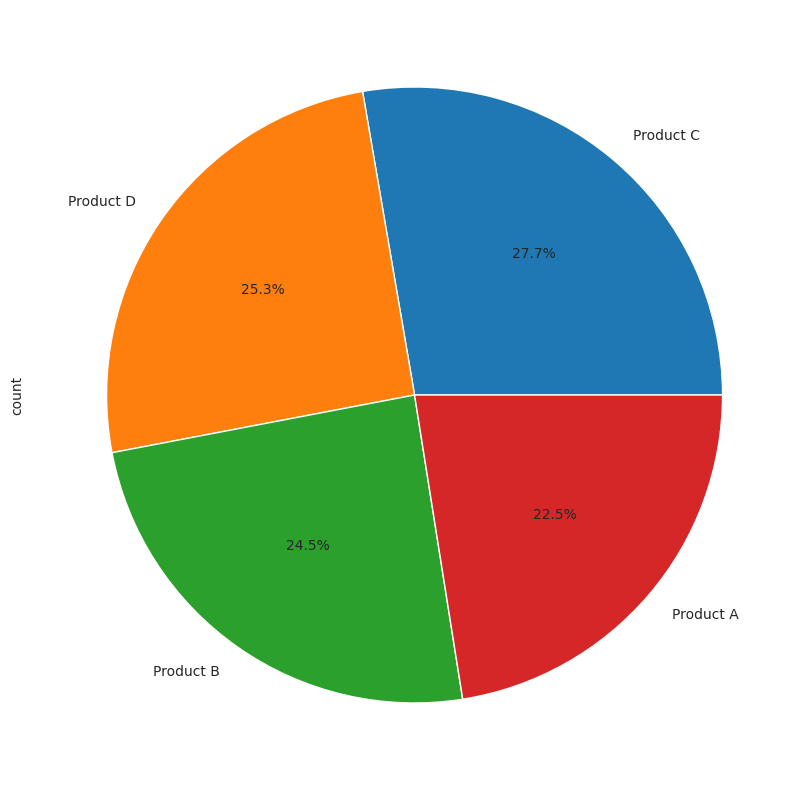

In [9]:
df.ProductInformation.value_counts().plot.pie(autopct='%1.1f%%')
plt.tight_layout()

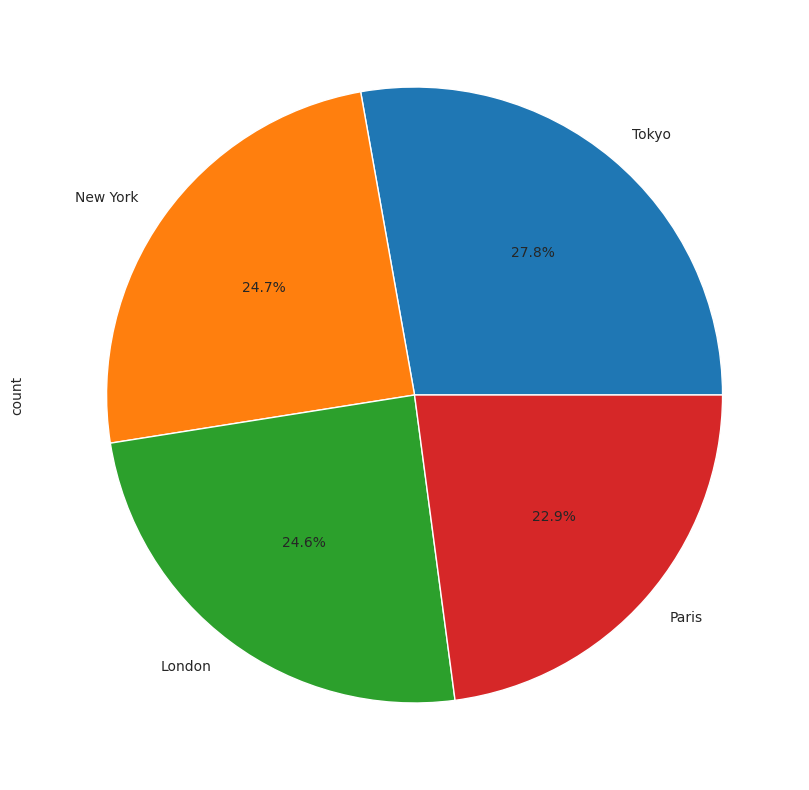

In [10]:
df.Location.value_counts().plot.pie(autopct='%1.1f%%')
plt.tight_layout()

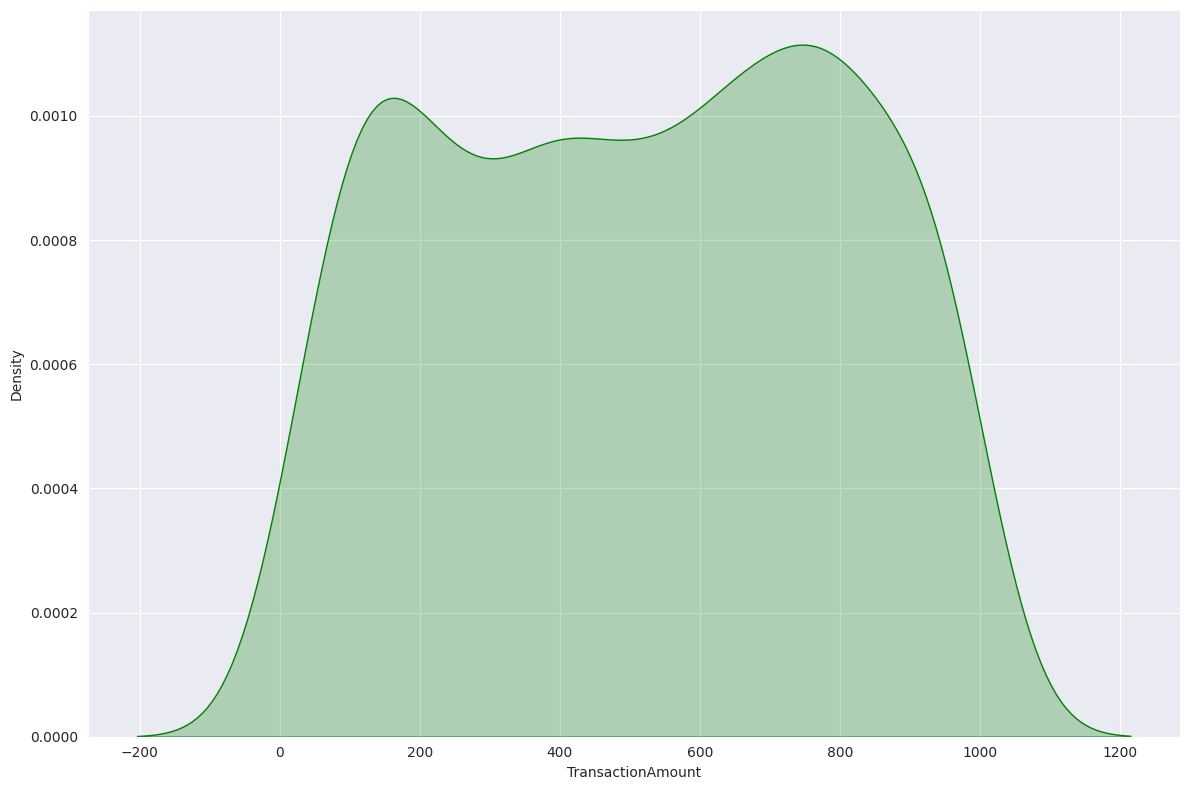

In [11]:
sns.kdeplot(df.TransactionAmount, fill=True, color='g')
plt.tight_layout()

## 4. Data Preprocessing

### RFM Features
First let's calculate the RFM features. The RFM features are:
- **Recency**: The number of days since the last purchase.
- **Frequency**: The number of purchases.
- **Monetary**: The total amount spent.
We will calculate the RFM features for each customer grouping by the customer ID.

In [12]:
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

- We will calculate the recency, frequency, and monetary for each customer grouping by the customer ID.
- We will use 1 day lag to last purchase date to calculate the recency.

In [13]:
# Display the last purchase date in the dataset.
df['PurchaseDate'].max()

Timestamp('2023-06-10 00:00:00')

In [14]:
# 1 day lag to last purchase date to calculate the recency.
analysis_date = datetime(2023, 6, 11)

rfm_df = df.groupby('CustomerID').agg({
    'PurchaseDate': lambda x: (analysis_date - x.max()).days,
    'OrderID': 'nunique',
    'TransactionAmount': 'sum'
})
rfm_df.columns = ['Recency', 'Frequency', 'Monetary']

In [15]:
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
1011,34,2,1129.02
1025,22,1,359.29
1029,1,1,704.99
1046,44,1,859.82
1049,14,1,225.72


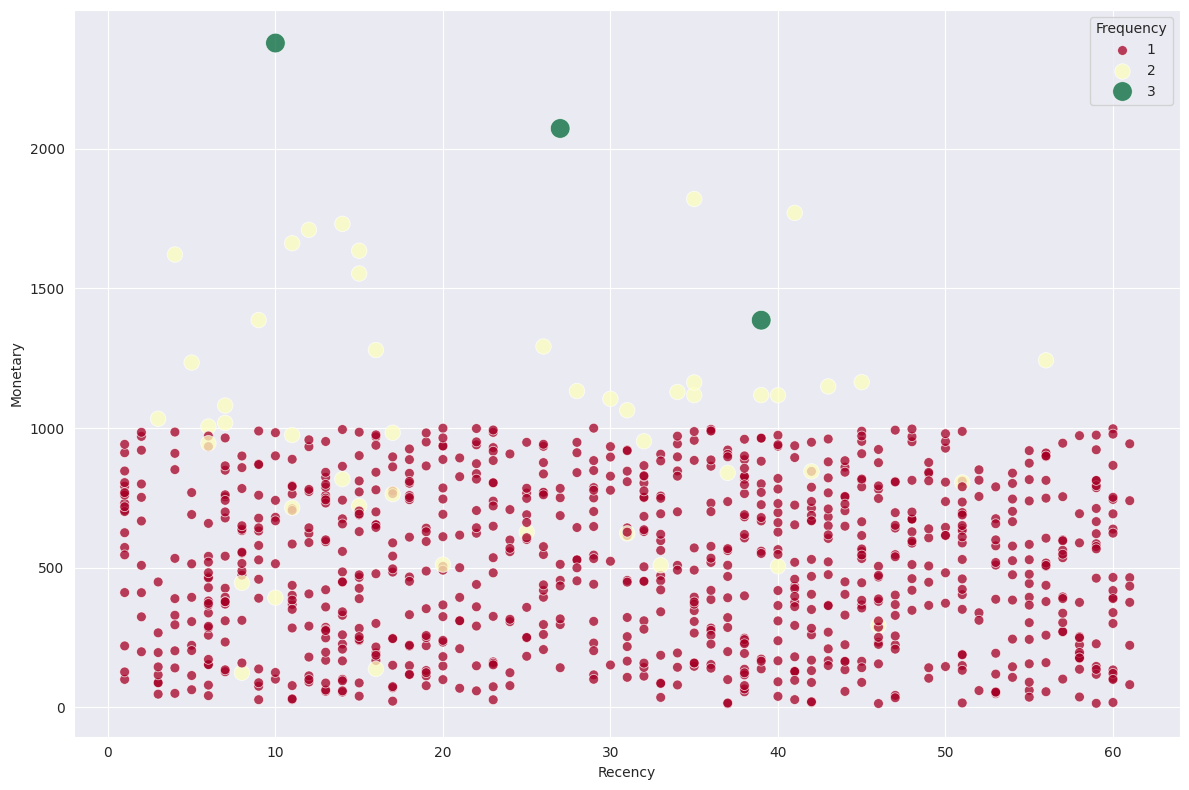

In [16]:
sns.scatterplot(
    rfm_df,
    x='Recency',
    y='Monetary',
    hue='Frequency',
    size='Frequency',
    sizes=(50, 200),
    alpha=0.75,
    palette='RdYlGn'
)
plt.tight_layout()

### Scoring
Let's score the customers using the RFM features.
We will use the following scoring method:
- Recency: 1-5, 1 being the most recent purchase and 5 being the oldest purchase.
- Frequency: 1-5, 1 being the least frequent and 5 being the most frequent.
- Monetary: 1-5, 1 being the least monetary and 5 being the most monetary.

In [17]:
# Recency score (low number of days = high score)
rfm_df['RecencyScore'] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1])

In [18]:
# Frequency score (high frequency = high score)
# The .rank(method="first") command prevents qcut from failing when there are multiple customers with the same frequency value.
rfm_df['FrequencyScore'] = pd.qcut(rfm_df['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

In [19]:
# Monetary score (high spending = high score)
rfm_df['MonetaryScore'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1, 2, 3, 4, 5])

In [20]:
rfm_df.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore
CustomerID,,,,,,
1011,34,2,1129.02,3,5,5
1025,22,1,359.29,4,1,2
1029,1,1,704.99,5,1,4
1046,44,1,859.82,2,1,5
1049,14,1,225.72,4,1,2


## 5. RFM Clustering

Let's calculate the RF score.
The RF score is the sum of the `RecencyScore` and `FrequencyScore`.
We will use the RF score to cluster the customers.

<div align="center">
<img src="https://miuul.com/image/article/62b8404e1ec8d.png" />
</div>

> This picture shows segments distribution by R and F values

In [21]:
# Concatenate Recency and Frequency scores to create a single RF_Score
rfm_df['RF_Score'] = rfm_df['RecencyScore'].astype(str) + rfm_df['FrequencyScore'].astype(str)

# Define the segmentation map
segmentation_map = {
    r'[1-2][1-2]': 'Hibernating',        # Haven't purchased for a long time and made few purchases
    r'[1-2][3-4]': 'At_Risk',            # Haven't purchased for a long time but used to purchase frequently
    r'[1-2]5': 'Cant_Lose',              # Customers that shouldn't be lost (used to be most frequent)
    r'3[1-2]': 'About_to_Sleep',         # About to fall asleep
    r'33': 'Need_Attention',             # Need attention (average R and F)
    r'[3-4][4-5]': 'Loyal_Customers',    # Loyal Customers (purchase frequently)
    r'41': 'Promising',                  # Promising (purchased recently but not frequently)
    r'51': 'New_Customers',              # New Customers (most recent, first purchase)
    r'[4-5][2-3]': 'Potential_Loyalists',# Potential Loyalists
    r'5[4-5]': 'Champions'               # Champions (most recent and purchase frequently)
}

# Create segments based on the RF_SCORE
rfm_df['Segment'] = rfm_df['RF_Score'].replace(segmentation_map, regex=True)

In [22]:
rfm_df.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RF_Score,Segment
CustomerID,,,,,,,,
1011,34,2,1129.02,3,5,5,35,Loyal_Customers
1025,22,1,359.29,4,1,2,41,Promising
1029,1,1,704.99,5,1,4,51,New_Customers
1046,44,1,859.82,2,1,5,21,Hibernating
1049,14,1,225.72,4,1,2,41,Promising


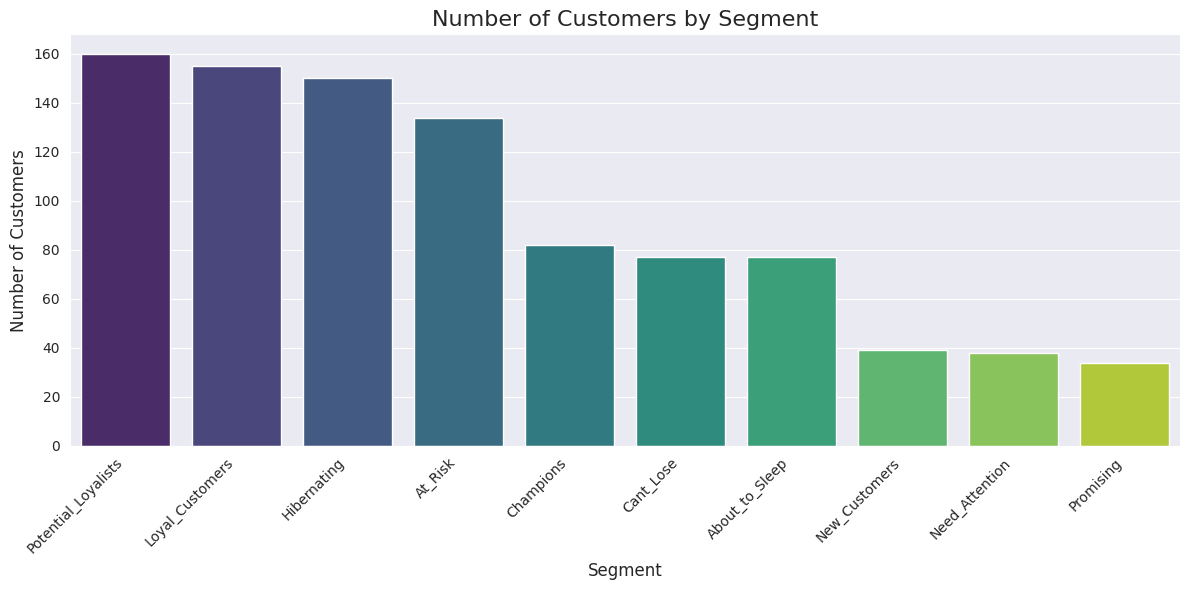

In [23]:
# Plot the segments
plt.figure(figsize=(12, 6))
sns.countplot(data=rfm_df, x='Segment', palette='viridis', order=rfm_df['Segment'].value_counts().index)
plt.title('Number of Customers by Segment', fontsize=16)
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

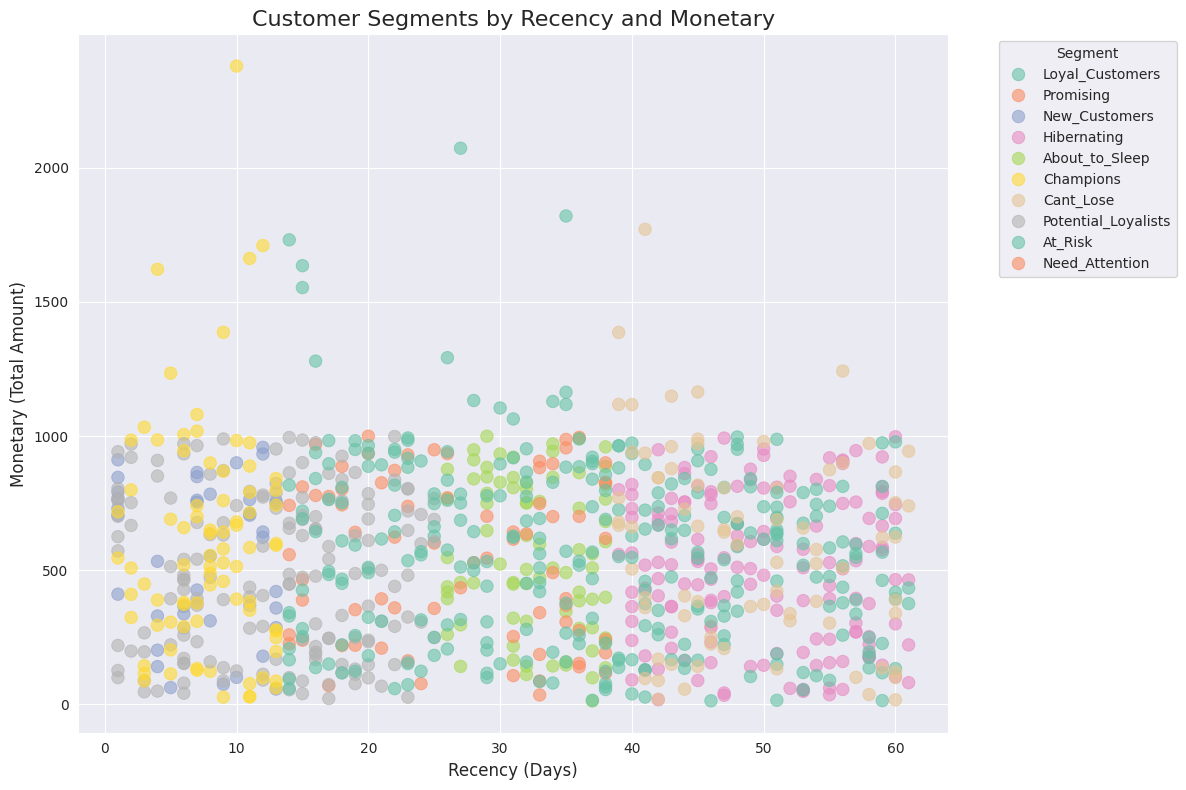

In [24]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=rfm_df,
    x='Recency',
    y='Monetary',
    hue='Segment',
    palette='Set2',
    s=80,
    alpha=0.6,
    edgecolor=None
)
plt.title('Customer Segments by Recency and Monetary', fontsize=16)
plt.xlabel('Recency (Days)', fontsize=12)
plt.ylabel('Monetary (Total Amount)', fontsize=12)
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [25]:
fig = px.treemap(rfm_df, path=['Segment', 'RecencyScore', 'FrequencyScore'], values='Monetary', color='Segment')
fig.show()

## 6. Conclusion
This project implemented an end-to-end RFM pipeline to segment customers by
engagement and value. We computed Recency, Frequency, and Monetary features,
created quantile-based scores, derived RF segments via a rules map, and
visualized segment distributions and relationships (count plot, scatter, treemap)
to highlight groups like `Champions`, `Loyal_Customers`, and `At_Risk`.

### Key features:
- Clean, reproducible RFM feature calculation and scoring
- Intuitive rule-based RF segmentation with clear labels
- Multiple visualizations to interpret segment size and value

### Future improvements:
- Add monetary to the rule map or adopt full RFM-based clustering (e.g., KMeans)
- Calibrate cut-points per business using domain thresholds instead of pure quantiles
- Enrich with churn indicators, lifetime value estimates, and campaign response
- Build a simple app/dashboard to operationalize segment targeting